# Импорт данных

Будем сравнивать различные модели для базового прогноза. 

### Для этого импортируем несколько различных показателя:
- Индекс промышленного производства
- Индекс потребительских цен
- Внешнеторговый оборот
- Инвестиции в основной капитал
- Оборот розничной торговли
- Обьем вкладов

### И создадим два искусственных
- Полином
- Синусойд с полиномиальным трендом 

### Также сравним качество предсказаний для:
- квартальных и ежемесячных даннных
- с сезонностью (в % к предыдущему месяцу) и без сезонности (В % к соответствующему периоду предыдущего года)

In [21]:
import numpy as np
import pandas as pd
from datetime import date

In [163]:
date_start = date(year=2015, month=1, day=1)

def data_prerpocess(df):
    """Приводим дату к нужнмоу формату, удаляем лишние столбцы, сортируем по дате, оставим только от 2015 года"""
    
    df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y').dt.date

    return df.drop(columns=['dataset'])\
             .sort_values(by='date', ascending=False)\
             [df.date >= date_start]

### Макроиндексы

In [94]:
path = './данные для исследований/'

In [211]:
indexes = {
    'Импорт': pd.read_csv(path + 'Внешнеторговый оборот, Россия — Диаграмма.csv', sep=';'),
    'Инвестиции в основной капитал': pd.read_csv(path + 'Инвестиции в основной капитал организаций.csv', sep=';'),
    'ИПЦ': pd.read_csv(path + 'Индекс потребительских цен, Россия — Диаграмма.csv', sep=';'),
    'ИПП': pd.read_csv(path + 'Индекс промышленного производства, Россия — Диаграмма.csv', sep=';'),
    'Оборот розничной торговли': pd.read_csv(path + 'Оборот розничной торговли, Россия — Диаграмма.csv', sep=';'),
    'Обьем вкладов': pd.read_csv(path + 'Объем вкладов (депозитов).csv', sep=';')
}

indexes = {index: data_prerpocess(df) for index, df in indexes.items()}

/tmp/ipykernel_37236/3500740048.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return df.drop(columns=['dataset'])\
/tmp/ipykernel_37236/3500740048.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return df.drop(columns=['dataset'])\
/tmp/ipykernel_37236/3500740048.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return df.drop(columns=['dataset'])\
/tmp/ipykernel_37236/3500740048.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return df.drop(columns=['dataset'])\
/tmp/ipykernel_37236/3500740048.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return df.drop(columns=['dataset'])\
/tmp/ipykernel_37236/3500740048.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return df.drop(columns=['dataset'])\


### Искусственные данные

In [165]:
x = np.arange(-5, 5, 0.1)

sin_polinom = 5 * np.sin(x) + (x ** 3 - 3 * x ** 2 + x)/ 10
polinom = (x ** 3 - 3 * x ** 2 + x)/ 10

# Визуализация

In [33]:
import matplotlib.pyplot as plt

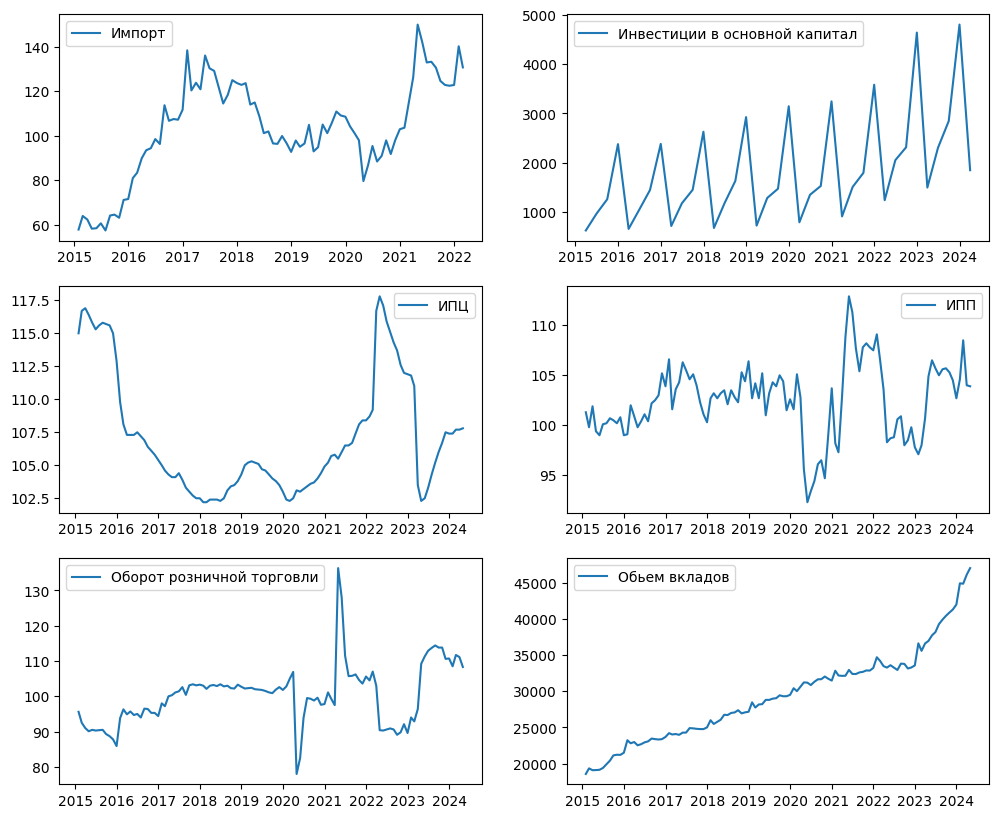

In [212]:
fig, axes = plt.subplots(3, 2, figsize=(12, 10))

k = 0
for i in range(3):
    for j in range(2):
        label, data = list(indexes.items())[k]
        k += 1
                
        axes[i][j].plot(data.date, data.iloc[:, 1], label=label)
        axes[i][j].legend()


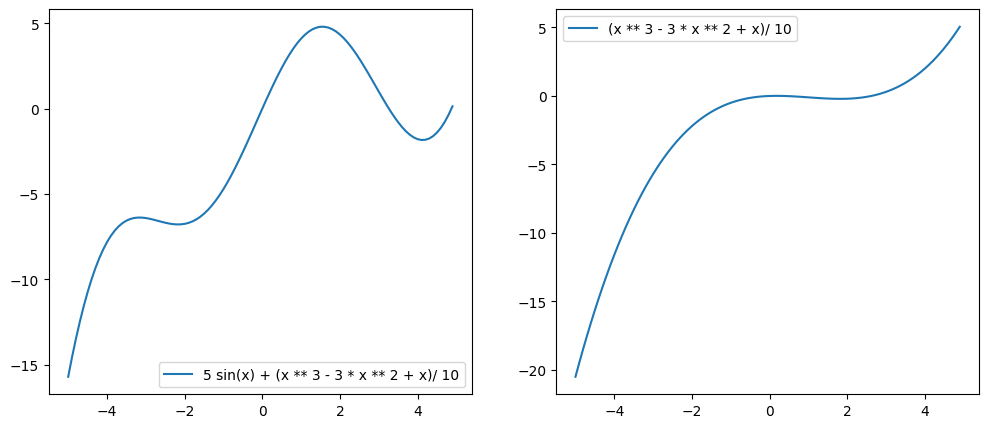

In [219]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(x, sin_polinom, label='5 sin(x) + (x ** 3 - 3 * x ** 2 + x)/ 10')
axes[1].plot(x, polinom, label='(x ** 3 - 3 * x ** 2 + x)/ 10')

axes[0].legend()
axes[1].legend()

# Предобработка

Приведем к значениям от 0 до 1, чтобы улучшить качество нейросети

In [220]:
from sklearn.preprocessing import StandardScaler

In [221]:
scalers = dict()

for index, df in indexes.items():
    goal = df.columns[-1]
    
    scalers[index] = StandardScaler().fit(df[[goal]])
    df['z_goal'] = scalers[index].transform(df[[goal]])

In [223]:
indexes['ИПЦ'].head(3)

,date,"Индекс потребительских цен, Россия: в % к предыдущему месяцу",z_goal
303,2024-04-30,107.8,0.161025
302,2024-03-31,107.7,0.138869
301,2024-02-29,107.7,0.138869


и обратно переводим

In [224]:
scalers['ИПЦ'].inverse_transform(indexes['ИПЦ'][['z_goal']])[:3]

array([[107.8],
       [107.7],
       [107.7]])

# Создание модели

- Сравним GRU и LSTM
- А также сравним итерационные модели, и модели которые сразу возвращают вектор значений

In [188]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsolutePercentageError
from tensorflow.keras.layers import GRU, LSTM, BatchNormalization, Dropout, Dense, TimeDistributed

tf.compat.v2.random.set_seed(1)

## Гиперпараметры модели

In [232]:
from dataclasses import dataclass, field

@dataclass
class ModelConfig:
    lookback         = 6   # Сколько берем данных для прогноза
    forecast_horizon = 3   # На сколько делаем прогноз
    n_layers         = 2   # Количество слоев
    units            = 2   # Количество нейронов на каждом слое
    batch_size       = 64
    epochs           = 100
    
    input_shape: tuple = (lookback, 1)

## Создание модели

In [275]:
def get_model(lstm=True, vector=True):
    """
    - Если lstm = True, то будет создана модель архитектуры LSTM, иначе GRU
    - Если vector = True, то возвращаемым значением будет вектор длины ModelConfig.forecast_horizon, иначе 1
    """
    
    model = Sequential()
    Model = LSTM if lstm else GRU
    horizon = ModelConfig.forecast_horizon if vector else 1
        
    for i in range(ModelConfig.n_layers - 1):
        model.add(Model(units=ModelConfig.units, return_sequences=True, input_shape=(ModelConfig.lookback, 1)))
        
    model.add(Model(units=ModelConfig.units, return_sequences=False, input_shape=(ModelConfig.lookback, 1)))
    model.add(Dense(units=horizon, activation='linear'))
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=[MeanAbsolutePercentageError()])

    return model

# Обучение моделей

In [239]:
import numpy as np
from typing import Iterable
from sklearn.model_selection import train_test_split

In [240]:
def prepare_rnn_data(data: Iterable, lookback: int, horizon: int) -> tuple[np.array, np.array]:
    """
    Создает батчи по lookback месяцев для иксов и по horizon месяца для игреков
    
    Также приводит к формату данных для RNN
    """
    
    data_range = range(lookback, len(data) - horizon + 1)
    
    x = np.array([data[i - lookback:i] for i in data_range])
    x = np.reshape(x, (x.shape[0], lookback, 1))

    y = np.array([data[i:i + horizon] for i in data_range])
    
    return x, y

# Векторные модели

In [249]:
lookback = ModelConfig.lookback
horizon = ModelConfig.forecast_horizon

In [281]:
models = dict()
models['векторные'] = dict()
models['векторные']['lstm'] = dict()
models['итерационные'] = dict()
models['итерационные']['gru'] = dict()

### LSTM

In [284]:
def learn_all_models(lstm=True, vector=True):
    for index, df in indexes.items():
        # получение данных
        X, y = prepare_rnn_data(df['z_goal'].values, lookback, horizon)
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
        x_val, y_val = x_test[-12:], y_test[-12:]
        print(f'{X.shape = }, {y.shape = }\t{index}')
        
        
        model = get_model(lstm=lstm, vector=vector)
        model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=ModelConfig.batch_size, epochs=ModelConfig.epochs)
     
        lstm_type = ['gru', 'lstm'][lstm]
        vector_type = ['итерационные', 'векторные'][vector]

        models[vector_type][lstm_type][index] = model

In [285]:
learn_all_models()

X.shape = (78, 6, 1), y.shape = (78, 3)	Импорт
3
Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.7707 - mean_absolute_percentage_error: 129.7166 - val_loss: 0.7592 - val_mean_absolute_percentage_error: 91.9269
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.7696 - mean_absolute_percentage_error: 129.8416 - val_loss: 0.7582 - val_mean_absolute_percentage_error: 91.8480
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.7684 - mean_absolute_percentage_error: 129.9685 - val_loss: 0.7573 - val_mean_absolute_percentage_error: 91.7688
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.7672 - mean_absolute_percentage_error: 130.0973 - val_loss: 0.7564 - val_mean_absolute_percentage_error: 91.6893
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.7661 - mean_absolute_percentage_error: 130.2281 - val_loss: 0.7554 - val_mean_absolute_percentage_error: 91.6096
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.7649 - mean_absolute_percent


KeyboardInterrupt



# Предсказания моделей

In [258]:
model  = models['векторные']['ИПП']
df     = indexes['ИПП']
scaler = scalers['ИПП']

In [264]:
model.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_23 (LSTM)                  │ (None, 6, 2)           │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_24 (LSTM)                  │ (None, 2)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 3)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 245 (984.00 B)

 Trainable params: 81 (324.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 164 (660.00 B)

In [263]:
scaler.inverse_transform(model.predict(X[0]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


array([[102.359344, 102.420395, 102.50833 ],
       [102.35821 , 102.42014 , 102.50721 ],
       [102.337036, 102.42015 , 102.47285 ],
       [102.3519  , 102.418884, 102.50069 ],
       [102.37404 , 102.42385 , 102.52202 ],
       [102.35288 , 102.41907 , 102.50175 ]], dtype=float32)

In [259]:
X, y = prepare_rnn_data(df['z_goal'].values, lookback, horizon)

predictions = list()

for x in X:
    predictions.append(scaler.inverse_transform(model.predict(x)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━